In [1]:
import pandas as pd
import geopandas
import json
import os
from shapely.geometry import Point
import difflib
from geopy.distance import vincenty
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
inline_rc = dict(mpl.rcParams)


In [2]:
#in_folder = "audits/2018_07/data/"
out_folder = "audits/2018_11/images/"
in_folder = "../data/"
#out_folder = "/tmp"

# Mesures quantitatives

In [3]:
#on charge les contenus géographiques qu'on utilisera
zones = geopandas.read_file('ref_data/idf_departements.geojson', driver='GeoJSON')
zones = zones[['name', 'geometry']]
#zones.plot()

## Nombre de points d'arrêts

In [4]:
#on charge les données
osm_stoppoints = pd.read_csv(os.path.join(in_folder,"osm-transit-extractor_stop_points.csv"), dtype=str)
gtfs_stoppoints = pd.read_csv(os.path.join(in_folder,"gtfs_stops.txt"), dtype=str)
gtfs_stoppoints = gtfs_stoppoints[gtfs_stoppoints['location_type'] == '0'] #on retire les zones d'arrêts

#on ajoute la dimension géographique
crs = {'init': 'epsg:4326'}
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['stop_lon']),float(row['stop_lat']))

gtfs_stoppoints['geometry'] = gtfs_stoppoints.apply(gtfs_lat_lon_to_geom, axis=1)
gtfs_stoppoints.drop('stop_lon', axis=1, inplace=True)
gtfs_stoppoints.drop('stop_lat', axis=1, inplace=True)

def osm_lat_lon_to_geom(row):
    return Point(float(row['lon']),float(row['lat']))

osm_stoppoints['geometry'] = osm_stoppoints.apply(osm_lat_lon_to_geom, axis=1)
osm_stoppoints.drop('lon', axis=1, inplace=True)
osm_stoppoints.drop('lat', axis=1, inplace=True)

osm_stops_geo = geopandas.GeoDataFrame(osm_stoppoints, crs=crs, geometry=osm_stoppoints.geometry)
gtfs_stops_geo = geopandas.GeoDataFrame(gtfs_stoppoints, crs=crs, geometry=gtfs_stoppoints.geometry)

#on calcule le nombre par département
gtfs_stoppoints_with_zones = geopandas.sjoin(gtfs_stops_geo, zones.copy(), op='within')
counts_gtfs_stops = gtfs_stoppoints_with_zones.groupby('name').size()
zones_with_gtfs_stops_count = zones[['name', 'geometry']].merge(counts_gtfs_stops.reset_index(name='nb_stoppoints_officiel'))

osm_stoppoints_with_zones = geopandas.sjoin(osm_stops_geo, zones.copy(), op='within')
counts_osm_stops = osm_stoppoints_with_zones.groupby('name_right').size()
zones_with_stoppoints_count = zones_with_gtfs_stops_count.merge(counts_osm_stops.reset_index(name='nb_stoppoints_osm'), left_on="name", right_on='name_right')
zones_with_stoppoints_count.drop('name_right', axis=1, inplace=True)

#on calcule le pourcentage de couverture d'OSM par rapport à l'officiel
zones_with_stoppoints_count["couverture_stoppoints_osm"] = zones_with_stoppoints_count["nb_stoppoints_osm"] * 100.0 / zones_with_stoppoints_count["nb_stoppoints_officiel"]
zones_with_stoppoints_count = zones_with_stoppoints_count.sort_values("name").reset_index().drop("index", axis=1)
#zones_with_stoppoints_count


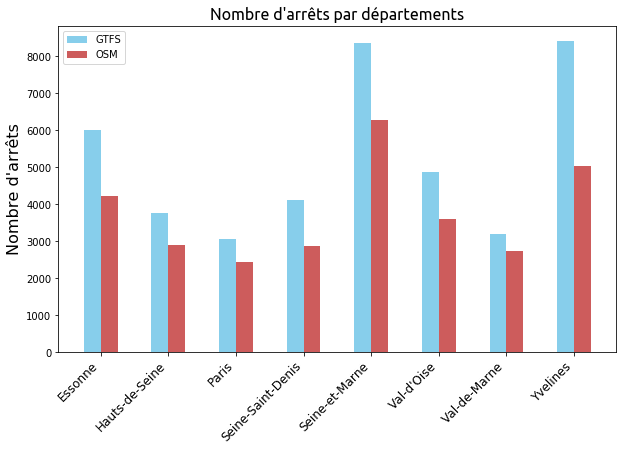

In [5]:
#histogramme de la couverture en pourcentage par département
mpl.rcParams.update(inline_rc) # reset du style 

width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(ind - width/2, zones_with_stoppoints_count["nb_stoppoints_officiel"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, zones_with_stoppoints_count["nb_stoppoints_osm"], 
                width, color='IndianRed', label='OSM')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Nombre d\'arrêts par départements', 
             fontname='Ubuntu', fontsize=16,
             fontstyle='normal', fontweight='normal')
ax.set_ylabel('Nombre d\'arrêts', fontsize=16)

ax.set_xticks(ind)
ax.set_xticklabels(zones_with_stoppoints_count["name"], rotation=45, ha='right', fontsize=12)
ax.legend()

plt.savefig(os.path.join(out_folder, '1_stoppoints_per_deptm_chart.png'), bbox_inches='tight')

Pourcentage de couverture global sur l'Île-de-France en points d'arrêts:

In [6]:
len(osm_stoppoints) * 100.0 / len(gtfs_stoppoints)

71.55599838682893

NB : les données OSM sont déjà filtrées sur les bus, mais pas les données officielles

## Nombre de lignes

In [7]:
# on charge les lignes dans les deux sources
gtfs_lines = pd.read_csv(os.path.join(in_folder, "gtfs_routes.txt"), dtype=str)
gtfs_lines = gtfs_lines[gtfs_lines['route_type'] == '3']

osm_lines = pd.read_csv(os.path.join(in_folder, "osm-transit-extractor_lines.csv"), dtype=str)
osm_lines = osm_lines[osm_lines['mode'] == 'bus']

Pourcentage de couverture en lignes de bus:

In [8]:
len(osm_lines) * 100.0 / len(gtfs_lines)

59.396506087877185

## Nombre de routepoints

In [9]:
#préparation géographique des données officielles pour les routepoints
gtfs_routepoints = pd.read_csv(os.path.join(in_folder,"opendata_routepoints.csv"), dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
crs = {'init': 'epsg:4326'}   
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['gtfs_stop_lon']),float(row['gtfs_stop_lat']))

gtfs_routepoints['geometry'] = gtfs_routepoints.apply(gtfs_lat_lon_to_geom, axis=1)

gtfs_geo = geopandas.GeoDataFrame(gtfs_routepoints, crs=crs, geometry=gtfs_routepoints.geometry)
#gtfs_geo.plot(markersize=0.5, figsize=(10, 10))

gtfs_routepoints_with_zones = geopandas.sjoin(gtfs_geo, zones.copy(), op='within')
counts_gtfs = gtfs_routepoints_with_zones.groupby('name').size()
zones_with_gtfs_count = zones.merge(counts_gtfs.reset_index(name='nb_stops_officiel'))

In [10]:
#préparation géographique des données OSM pour les routepoints
osm_routepoints = pd.read_csv(os.path.join(in_folder, "osm_routepoints.csv"), dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)
def osm_lat_lon_to_geom(row):
    return Point(float(row['osm_lon']),float(row['osm_lat']))

osm_routepoints['geometry'] = osm_routepoints.apply(osm_lat_lon_to_geom, axis=1)
osm_routepoints.drop('osm_lon', axis=1, inplace=True)
osm_routepoints.drop('osm_lat', axis=1, inplace=True)

osm_geo = geopandas.GeoDataFrame(osm_routepoints, crs=crs, geometry=osm_routepoints.geometry)
#osm_geo.plot(markersize=0.5, figsize=(10, 10))

osm_routepoints_with_zones = geopandas.sjoin(osm_geo, zones.copy(), op='within')
counts_osm = osm_routepoints_with_zones.groupby('name').size()
zones_with_routepoints_count = zones_with_gtfs_count.merge(counts_osm.reset_index(name='nb_stops_osm'))
zones_with_routepoints_count["couverture_osm"] = zones_with_routepoints_count["nb_stops_osm"] * 100.0 / zones_with_routepoints_count["nb_stops_officiel"]

zones_with_routepoints_count.sort_values("name", inplace=True)
#zones_with_routepoints_count

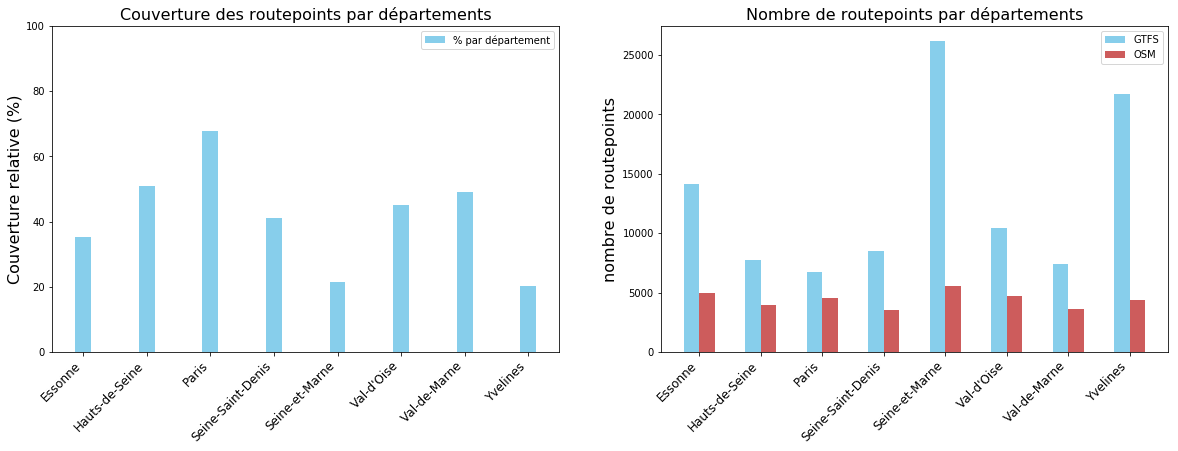

In [11]:
# histogramme de la couverture en pourcentage par département
mpl.rcParams.update(inline_rc) # reset du style 

width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
fig = plt.figure(figsize=(20, 6))
# 1er graph
ax = fig.add_subplot(121)
rects = ax.bar(ind, zones_with_routepoints_count["couverture_osm"], 
                width, color='SkyBlue', label='% par département')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(0, 100)
ax.set_ylabel('Couverture relative (%)', fontsize=16)
ax.set_title('Couverture des routepoints par départements', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(zones_with_routepoints_count["name"], rotation=45, ha='right', fontsize=12)
ax.legend()

# 2eme graph
ax = fig.add_subplot(122)
width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
rects1 = ax.bar(ind - width/2, zones_with_routepoints_count["nb_stops_officiel"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, zones_with_routepoints_count["nb_stops_osm"], 
                width, color='IndianRed', label='OSM')
ax.set_ylabel('nombre de routepoints', fontsize=16)
ax.set_title('Nombre de routepoints par départements', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(zones_with_routepoints_count["name"], rotation=45, ha='right', fontsize=12)
ax.legend()


plt.savefig(os.path.join(out_folder,'3_routepoints_per_deptm.png'), bbox_inches='tight')

Pourcentage global de couverture OSM sur l'Île-de-France en routepoints : 

In [12]:
len(osm_routepoints) * 100.0 / len(gtfs_routepoints)

34.2109588776191

## Complétude des réseaux cartographiés

In [13]:
osm_routepoints_cleaned = osm_routepoints.copy()

#attention à ces deux mappings à ne pas faire
#osm_routepoints_cleaned.replace(to_replace="Navettes Aéroports De Paris", value="ADP", inplace=True)
#osm_routepoints_cleaned.replace(to_replace="R'bus", value="rbus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Les Courriers de l'Île-de-France", value="CIF", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Keolis CIF", value="CIF", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Bus Val d'Oise", value="Busval d'Oise", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Transdev CEAT", value="CEAT", inplace=True)
osm_routepoints_cleaned.replace(to_replace="La Navette Paris-Saclay", value="Paris-Saclay", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Réseau interurbain de Rambouillet", value="Rambouillet Interurbain", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Canton de Perthes en Gâtinais", value="Réseau du Canton de Perthes", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Seine-et-Marne Express", value="Seine et Marne Express", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Sénart Bus", value="Sénart-Bus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Tice", value="TICE", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Sit'bus", value="Sit'Bus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Situs", value="SITUS", inplace=True)
osm_routepoints_cleaned.replace(to_replace="SQYbus", value="SQYBus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="SQYBUS", value="SQYBus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="SqyBus", value="SQYBus", inplace=True)
osm_routepoints_cleaned.replace(to_replace="TransVO", value="Trans Val d'Oise", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Still", value="STILL", inplace=True)
osm_routepoints_cleaned.replace(to_replace="Î", value="I", inplace=True)
osm_routepoints_cleaned.replace(to_replace="R'bus", value="R'Bus", inplace=True)

osm_networks = pd.DataFrame(osm_routepoints_cleaned.groupby('osm_network').size()).reset_index()
osm_networks.rename(columns={0: 'osm_routepoints_count'}, inplace=True)
osm_networks["osm_network_lower"] = osm_networks["osm_network"].str.lower()

gtfs_networks = pd.DataFrame(gtfs_routepoints.groupby('gtfs_agency_name').size()).reset_index()
gtfs_agency_line_count = gtfs_routepoints.groupby('gtfs_agency_name').gtfs_route_short_name.nunique().reset_index()
gtfs_networks = gtfs_networks.merge(gtfs_agency_line_count, how='left', on='gtfs_agency_name')
gtfs_networks.rename(columns={0: 'gtfs_routepoints_count', "gtfs_route_short_name":"gtfs_lines_count"}, inplace=True)
gtfs_networks['gtfs_agency_name_lower'] = gtfs_networks['gtfs_agency_name'].str.lower()
networks = gtfs_networks.merge(osm_networks, how='inner', right_on=['osm_network_lower'], left_on=['gtfs_agency_name_lower'])
networks.drop('osm_network', axis=1, inplace=True)
networks.drop('osm_network_lower', axis=1, inplace=True)
networks.drop('gtfs_agency_name_lower', axis=1, inplace=True)
networks['osm_couverture'] = networks['osm_routepoints_count'] * 100.0 / networks['gtfs_routepoints_count']

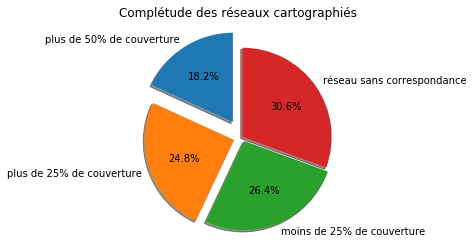

In [14]:
network_full_count = gtfs_networks.shape[0]
network_mapped_count = networks.shape[0]
networks_plus_50 = networks[networks["osm_couverture"] >= 50]
count_plus_50 = networks_plus_50.shape[0]
networks_plus_25 = networks[(networks["osm_couverture"] >= 25) & (networks["osm_couverture"] < 50)]
count_plus_25 = networks_plus_25.shape[0]
labels = 'plus de 50% de couverture', 'plus de 25% de couverture', 'moins de 25% de couverture', 'réseau sans correspondance'
portion_plus_50 = count_plus_50/network_full_count * 100
portion_plus_25 = count_plus_25/network_full_count * 100
portion_unmapped = (1 - network_mapped_count / network_full_count) * 100
portion_reste = 100 - portion_plus_50 - portion_plus_25 - portion_unmapped
sizes = [portion_plus_50, portion_plus_25, portion_reste, portion_unmapped]
explode = (0.2, 0.1, 0.05, 0)  

fig1, ax1 = plt.subplots()
ax1.set_title('Complétude des réseaux cartographiés')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.savefig(os.path.join(out_folder, '8_network_cover_in_routepoints.png'), bbox_inches='tight')

## Tracés des lignes

In [15]:
# on récupère le nombre de parcours de chaque ligne
osm_line_route = pd.read_csv(os.path.join(in_folder, "osm-transit-extractor_line_routes.csv"), dtype=str)
tt = pd.DataFrame(osm_line_route.groupby('line_id').count()).reset_index()
tt.rename(columns={'route_id': 'nb_routes'}, inplace=True)
result = pd.merge(osm_lines,tt, on='line_id')

osm_lines = result[['line_id', 'name', 'nb_routes','code', 'colour', 'operator', 'network','shape']].copy()

In [16]:
# on prépare les tracés pour analyse
from functools import partial
import pyproj
from shapely import wkt
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),
    pyproj.Proj(init='EPSG:2154'))

def osm_shape_to_wkt(row):
    if pd.isna(row['shape']):
        wkt_ = wkt.loads('POINT (2.482068 49.0327237)')
    else :
        wkt_ = wkt.loads(row['shape'])
    return transform(project, wkt_) # on projette, pour avoir plus tard la longueur en mètres

osm_lines['geom'] = osm_lines.apply(osm_shape_to_wkt, axis=1)
osm_lines_geo = geopandas.GeoDataFrame(osm_lines, geometry=osm_lines.geom)

#osm_lines_geo.plot()

In [17]:
osm_lines_geo['line_length'] = (osm_lines_geo.length/osm_lines_geo['nb_routes'] ) /1000
osm_lines_geo_ok = osm_lines_geo[osm_lines_geo['line_length'] >= 3].copy() #on supprime les trop petites lignes, qui doivent être incomplètes
osm_lines_geo_ok[['line_id', 'name', 'network', 'line_length']]

print("Nombre de lignes avec tracé : {}".format(len(osm_lines_geo_ok)))

tt = len(osm_lines_geo_ok) * 100.0 / len(osm_lines_geo)
"Pourcentage de lignes OSM qui ont un tracé : {}".format(tt)

Nombre de lignes avec tracé : 787


'Pourcentage de lignes OSM qui ont un tracé : 70.14260249554367'

In [18]:
## rapporté au nombre de lignes du GTFS
gtfs_lines = pd.read_csv(os.path.join(in_folder, "gtfs_routes.txt"), dtype=str)
gtfs_lines = gtfs_lines[gtfs_lines['route_type'] == '3']

tt = len(osm_lines_geo_ok) * 100.0 / len(gtfs_lines)
"Pourcentage de lignes qui ont un tracé : {}".format(tt)

'Pourcentage de lignes qui ont un tracé : 41.66225516146109'

# Mesures qualitatives

In [19]:
quali_osm_routepoints = pd.read_csv(os.path.join(in_folder, "osm_routepoints_for_matching.csv"), dtype=str)
for c in quali_osm_routepoints.columns:
    new_col = "osm_" + c
    quali_osm_routepoints.rename(columns={c: new_col}, inplace=True)

gtfs_routepoints = pd.read_csv(os.path.join(in_folder, "opendata_routepoints.csv"), dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
print("On a {:d} routepoints dans OSM et {:d} routepoints dans le GTFS".format(quali_osm_routepoints.shape[0], gtfs_routepoints.shape[0]))

On a 27540 routepoints dans OSM et 103423 routepoints dans le GTFS


In [20]:
quali_gtfs_routepoints = gtfs_routepoints.copy().fillna("")
quali_gtfs_routepoints = quali_gtfs_routepoints[quali_gtfs_routepoints['gtfs_ZDEr_ID_REF_A'] != '']

#on fusionne sur les codes d'arrêts et les codes de lignes
quali_routepoints = quali_gtfs_routepoints.merge(
                    quali_osm_routepoints, how='inner', 
                    right_on=["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line"],
                    left_on=["gtfs_ZDEr_ID_REF_A", "gtfs_route_id"]
               )
quali_routepoints.fillna("", inplace=True)

def compute_similarity_lower(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1.lower(), elem2.lower()).ratio()

def compute_similarity(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1, elem2).ratio()

#on fusionne sur les terminus de lignes
quali_routepoints['destination_confidence'] = quali_routepoints[['osm_destination','gtfs_dest_name']].apply(lambda x: compute_similarity_lower(*x), axis=1)
#quali_routepoints['destination_confidence'].hist()


In [21]:
#Pour la suite, on ne conserve que les routepoints qui matchent à 60% et plus
quali_routepoints_filtered = quali_routepoints[quali_routepoints['destination_confidence'] >= 0.6].copy()
"{:d} routepoints matchant à plus de 60%".format(quali_routepoints_filtered.shape[0])

quali_routepoints_filtered_export = quali_routepoints_filtered[['gtfs_stop_id', 'gtfs_route_id', 'gtfs_ZDEr_ID_REF_A', 'gtfs_dest_name', 'gtfs_stop_name',
                         'osm_stop_id','gtfs_agency_name', 'osm_osm:ref:FR:STIF:ExternalCode_Line','osm_osm:ref:FR:STIF', 'osm_destination', 'osm_name']]

quali_routepoints_filtered_export.to_csv(os.path.join(out_folder, 'mapping_des_routepoints.csv'))

tt = len(quali_routepoints_filtered) * 100.0 / len(gtfs_routepoints)
"Pourcentage de routepoints qu'on considère pour la suite : {}".format(tt)

"Pourcentage de routepoints qu'on considère pour la suite : 17.17993096313199"

In [22]:
print('Nombre total de parcours en utilisant les destinations pour les séparer des lignes :')
len(gtfs_routepoints.groupby(['gtfs_route_id','gtfs_dest_name']).size())

Nombre total de parcours en utilisant les destinations pour les séparer des lignes :


5690

## Code de ligne

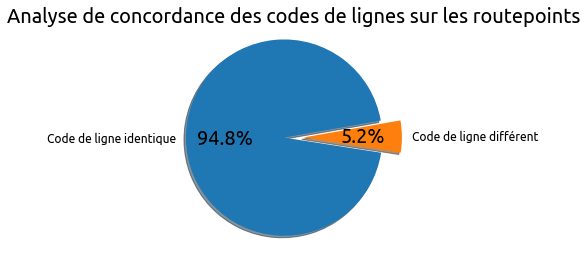

In [23]:
# différences sur les codes de ligne
quali_routepoints_filtered['line_code_confidence'] = quali_routepoints_filtered[['osm_code','gtfs_route_short_name']].apply(lambda x: compute_similarity(*x), axis=1)
quali_routepoints_filtered["line_code_confidence_rounded"] = quali_routepoints_filtered["line_code_confidence"].round(1) * 100

routepoints_count_total = quali_routepoints_filtered.shape[0]
routepoints_count_with_perfect_line_mapping = quali_routepoints_filtered[quali_routepoints_filtered["line_code_confidence_rounded"] == 100].shape[0]
routepoints_count_with_different_line_mapping = routepoints_count_total - routepoints_count_with_perfect_line_mapping
labels = 'Code de ligne identique', 'Code de ligne différent'


sizes = [routepoints_count_with_perfect_line_mapping/routepoints_count_total * 100, 
         routepoints_count_with_different_line_mapping/routepoints_count_total * 100]
explode = (0, 0.2)

mpl.rcParams.update(inline_rc) # reset du style 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 22
fig1, ax1 = plt.subplots()
ax1.set_title('Analyse de concordance des codes de lignes sur les routepoints')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig(os.path.join(out_folder, '11_routepoints_line_code_mapping_pie.png'), bbox_inches='tight')

## Noms des arrêts

In [24]:
quali_routepoints_filtered['name_confidence'] = quali_routepoints_filtered[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity(*x), axis=1)
quali_routepoints_filtered["name_confidence_rounded"] = quali_routepoints_filtered["name_confidence"].round(1) * 100
quali_routepoints_filtered['name_confidence_lower'] = quali_routepoints_filtered[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity_lower(*x), axis=1)
quali_routepoints_filtered["name_confidence_lower_rounded"] = quali_routepoints_filtered["name_confidence_lower"].round(1) * 100

routepoints_count = quali_routepoints_filtered.shape[0]
borne_identique = 0.9
borne_proche = 0.7
identiques = quali_routepoints_filtered[quali_routepoints_filtered['name_confidence'] >= borne_identique].shape[0]
proches = quali_routepoints_filtered[
    (quali_routepoints_filtered["name_confidence"] < borne_identique) & 
    (quali_routepoints_filtered["name_confidence"] >= borne_proche)].shape[0]
differents = quali_routepoints_filtered[quali_routepoints_filtered["name_confidence"] < borne_proche].shape[0]

identiques_lower = quali_routepoints_filtered[quali_routepoints_filtered['name_confidence_lower'] >= borne_identique].shape[0]
proches_lower = quali_routepoints_filtered[
    (quali_routepoints_filtered["name_confidence_lower"] < borne_identique) & 
    (quali_routepoints_filtered["name_confidence_lower"] >= borne_proche)].shape[0]
differents_lower = quali_routepoints_filtered[quali_routepoints_filtered["name_confidence_lower"] < borne_proche].shape[0]

#quali_routepoints_filtered[quali_routepoints_filtered['name_confidence'] >= borne_proche].sort_values("name_confidence")

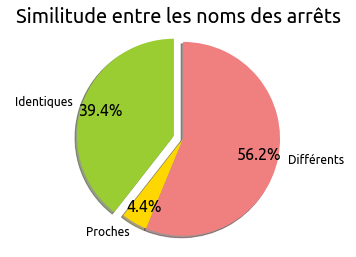

In [25]:
sizes = [identiques/routepoints_count * 100, 
         proches/routepoints_count * 100,
         differents/routepoints_count * 100]
sizes_lower = [identiques_lower/routepoints_count * 100, 
         proches_lower/routepoints_count * 100,
         differents_lower/routepoints_count * 100]
explode = (0.1, 0, 0)
colors = ['yellowgreen', 'gold', 'lightcoral']
labels = 'Identiques', 'Proches', 'Différents'

fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 16

ax1.set_title('Similitude entre les noms des arrêts')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        colors=colors,
        shadow=True, startangle=90, pctdistance=0.8)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(os.path.join(out_folder,'12_routepoints_name_mapping_pie.png'), bbox_inches='tight')

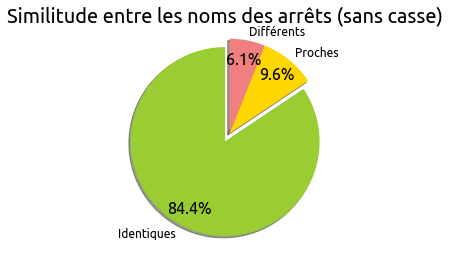

In [26]:
fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 16

ax1.set_title('Similitude entre les noms des arrêts (sans casse)')
ax1.pie(sizes_lower, explode=explode, labels=labels, autopct='%1.1f%%',
        colors=colors,
        shadow=True, startangle=90, pctdistance=0.8)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(os.path.join(out_folder,'12_routepoints_name_mapping_pie_lower.png'), bbox_inches='tight')

## Position des arrêts

In [27]:
def compute_distance(row):
    dist = vincenty(
        (float(row['osm_lat']), float(row['osm_lon'])), 
        (float(row['gtfs_stop_lat']), float(row['gtfs_stop_lon']))
    )
    return dist.meters
   
quali_routepoints_filtered['distance'] = quali_routepoints_filtered.apply(compute_distance, axis=1)
#quali_routepoints_filtered['distance'].hist()

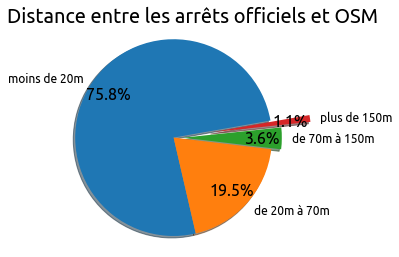

In [28]:
routepoints_count = quali_routepoints_filtered.shape[0]
labels = 'moins de 20m', 'de 20m à 70m', 'de 70m à 150m', 'plus de 150m'
count_moins_20 = quali_routepoints_filtered[quali_routepoints_filtered["distance"] < 20].shape[0]
count_20_70 = quali_routepoints_filtered[(quali_routepoints_filtered["distance"] >= 20) & (quali_routepoints_filtered["distance"] < 70)].shape[0]
count_70_150 = quali_routepoints_filtered[(quali_routepoints_filtered["distance"] >= 70) & (quali_routepoints_filtered["distance"] < 150)].shape[0]
count_plus_150 = quali_routepoints_filtered[quali_routepoints_filtered["distance"] >= 150].shape[0]

sizes = [count_moins_20/routepoints_count * 100, 
         count_20_70/routepoints_count * 100,
         count_70_150/routepoints_count * 100,
         count_plus_150/routepoints_count * 100]
explode = (0, 0, 0.1, 0.4)

fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 16

ax1.set_title('Distance entre les arrêts officiels et OSM')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10, pctdistance=0.8)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(os.path.join(out_folder,'14_routepoints_distance_pie_V2.png'), bbox_inches='tight')

In [29]:
print("Distance max : {:f}".format(quali_routepoints_filtered['distance'].max()))
print("Distance moyenne : {:f}".format(quali_routepoints_filtered['distance'].mean()))
print("Distance médiane : {:f}".format(quali_routepoints_filtered['distance'].median()))

routepoints_bad_position = quali_routepoints_filtered[quali_routepoints_filtered['distance'] > 70].copy()
print("Nombre de routepoints à plus de 70m : {:d}".format(len(routepoints_bad_position)))

print("Nombre de stoppoints du GTFS à plus de 70m : {:d}".format(
    len(routepoints_bad_position.groupby(['gtfs_stop_id'])[["distance"]].count()))
)

Distance max : 15963.264681
Distance moyenne : 20.390906
Distance médiane : 8.677137
Nombre de routepoints à plus de 70m : 829
Nombre de stoppoints du GTFS à plus de 70m : 605


In [30]:
routepoints_bad_position_export = routepoints_bad_position[['gtfs_stop_id', 'gtfs_route_id', 'gtfs_ZDEr_ID_REF_A', 'gtfs_dest_name', 'gtfs_stop_name',
                         'osm_stop_id', 'osm_osm:ref:FR:STIF:ExternalCode_Line','osm_osm:ref:FR:STIF', 'osm_destination', 'osm_name',
                              'distance']]
routepoints_bad_position_export.to_csv(os.path.join(out_folder, 'écart_positions_routepoints.csv'))

In [31]:
#osm_routepoints